In [94]:
%pip install opencv-python
%pip install tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import random
import shutil         

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix
from keras.layers import Conv2D, MaxPooling2D , BatchNormalization ,Dropout ,Flatten , Dense , Input , Rescaling , Resizing
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50 , VGG16 , VGG19 , InceptionV3 , Xception , InceptionResNetV2, MobileNetV2   
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout

import pandas as pd
import numpy as np
import seaborn as sns
import os
import cv2

import warnings
pd.set_option('display.max_colwidth', None)  
pd.set_option('display.expand_frame_repr', False)

plt.style.use('ggplot')


[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
directory= ["C:/Users/User/OneDrive/Desktop/IML/garbage_classification"]
Classes_chosen = ['metal', 'paper','glass','trash','battery','biological','plastic','clothes']
Paths = []
labels = []
for dir in directory:
    for className in os.listdir(dir):
        if className in Classes_chosen :
            classPath = os.path.join(dir,className)
            for img in os.listdir(classPath):
                imgPath = os.path.join(classPath,img)
                Paths.append(imgPath)
                labels.append(className)

df = pd.DataFrame({
    'imgPath':Paths,
    'label':labels
})
df = df.sample(frac=1).reset_index(drop=True)
df

In [ ]:
def Spliting(df , split , classesList):
    train = pd.DataFrame(columns = ['imgPath','label'])
    test = pd.DataFrame(columns = ['imgPath','label'])
    for clas in classesList :
        temp = df[df['label'] == clas]
        lastIndex = int(len(temp) * split)
        trainClass = temp[:lastIndex]
        testClass = temp[lastIndex:]
        train = pd.concat([train , trainClass] , axis=0)
        test = pd.concat([test , testClass] , axis=0)

    return train.sample(frac=1).reset_index(drop=True) , test.sample(frac=1).reset_index(drop=True) 

In [124]:
List = list(df['label'].unique())
train , test = Spliting(df , 0.85 , List)

In [126]:
train
train['label'].value_counts()

label
clothes       4526
glass         1709
paper         1649
biological     837
battery        803
plastic        735
metal          653
trash          592
Name: count, dtype: int64

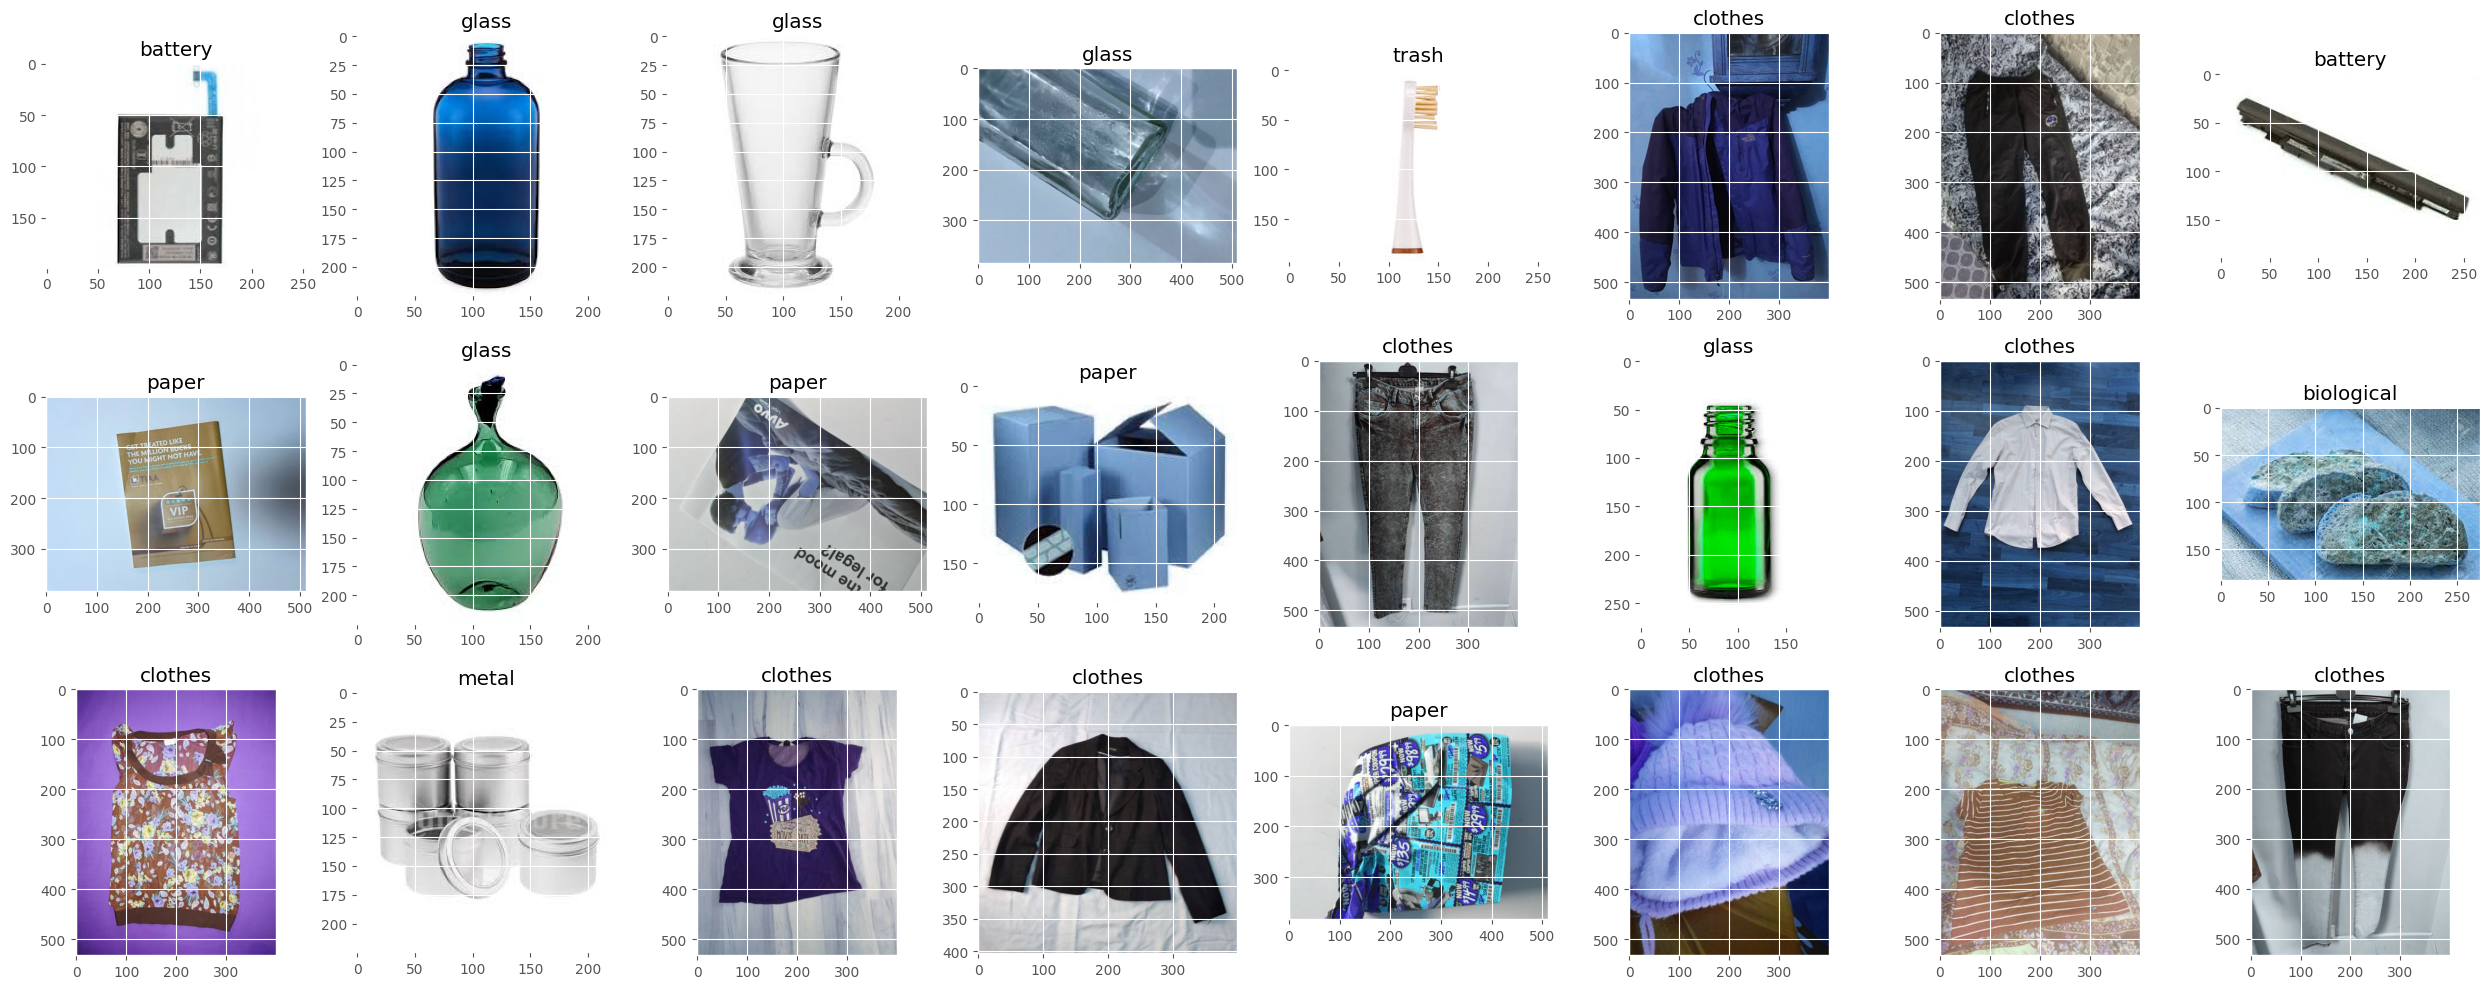

In [128]:
Paths = df['imgPath']
fig, axs = plt.subplots(3, 8, figsize=(25, 10))
axs = axs.flatten()

for ax,imgPath in zip(axs , Paths):
    label = str(imgPath).split('\\')[1]
    img = cv2.imread(imgPath)
    ax.imshow(img)
    ax.set_title(label)

plt.tight_layout()
plt.show()

In [187]:
dataTrain = ImageDataGenerator(
            rescale=1./255,
            zoom_range=(1.0, 1.2),
            vertical_flip=True,
            rotation_range=55,
            horizontal_flip=True,
)

In [188]:
SIZE = (224,224)

trainGenerator = dataTrain.flow_from_dataframe(
    train ,
    x_col='imgPath',
    y_col='label',
    target_size=SIZE,
    batch_size= 80 ,
    class_mode='categorical'
)


dataTest = ImageDataGenerator( rescale=1./255 )

testGenerator = dataTest.flow_from_dataframe(
    test ,
    x_col='imgPath',
    y_col='label',
    target_size=SIZE,
    batch_size= 20 ,
    class_mode='categorical',
    shuffle=False
)


print(f"Training set size: {trainGenerator.samples}")
print(f"Testing set size: {testGenerator.samples}")

Found 11504 validated image filenames belonging to 8 classes.
Found 2034 validated image filenames belonging to 8 classes.
Training set size: 11504
Testing set size: 2034


In [ ]:
Model = Sequential([
        MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), 
        Dense(60, activation='relu'),
        BatchNormalization(),
        Flatten(),
        Dropout(0.1),
        Dense(30, activation='relu'),
        Dense(8, activation='softmax')
    ])
Model.layers

[<Functional name=vgg16, built=True>,
 <Dense name=dense_31, built=False>,
 <BatchNormalization name=batch_normalization_13, built=False>,
 <Flatten name=flatten_13, built=False>,
 <Dropout name=dropout_13, built=False>,
 <Dense name=dense_32, built=False>,
 <Dense name=dense_33, built=False>]

In [191]:
preTrainedModel = Model.layers[0]
for layer in preTrainedModel.layers[:-5]:  
    layer.trainable = False
Model.compile(optimizer='adam',loss='categorical_crossentropy' ,metrics=['accuracy'])

In [192]:
history = Model.fit(trainGenerator,
                    validation_data = testGenerator,
                    epochs=25,
                    verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                                       patience=3,
                                       monitor='val_accuracy',
                                       restore_best_weights=True)])

Epoch 1/25


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 1481s 10s/step - accuracy: 0.6185 - loss: 1.1149 - val_accuracy: 0.7571 - val_loss: 0.7411
Epoch 2/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 1541s 11s/step - accuracy: 0.8064 - loss: 0.5514 - val_accuracy: 0.6814 - val_loss: 1.3174
Epoch 3/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 1494s 10s/step - accuracy: 0.8449 - loss: 0.4467 - val_accuracy: 0.7227 - val_loss: 1.0570
Epoch 4/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 1543s 11s/step - accuracy: 0.8630 - loss: 0.3983 - val_accuracy: 0.8073 - val_loss: 0.6916
Epoch 5/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 1477s 10s/step - accuracy: 0.8825 - loss: 0.3303 - val_accuracy: 0.8653 - val_loss: 0.4646
Epoch 6/25
 91/144 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - accuracy: 0.9033 - loss: 0.2885

KeyboardInterrupt: 

In [186]:
Model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 7, 7, 60)       │        76,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 7, 7, 60)       │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 2940)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 2940)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 30)             │        88,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 8)              │           248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,194,480 (16.00 MB)

 Trainable params: 885,458 (3.38 MB)

 Non-trainable params: 1,538,104 (5.87 MB)

 Optimizer params: 1,770,918 (6.76 MB)

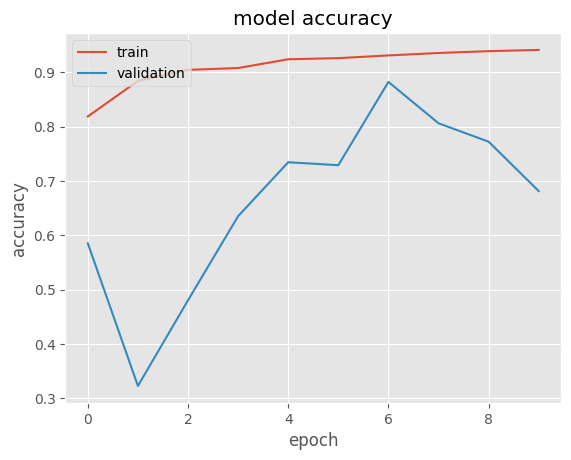

In [154]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [155]:
predictions = Model.predict(testGenerator)

102/102 ━━━━━━━━━━━━━━━━━━━━ 34s 325ms/step


In [156]:
trainGenerator.class_indices

{'battery': 0,
 'biological': 1,
 'clothes': 2,
 'glass': 3,
 'metal': 4,
 'paper': 5,
 'plastic': 6,
 'trash': 7}

In [157]:
trueClasses = testGenerator.classes
trueClasses[:20]

[1, 3, 0, 4, 2, 1, 2, 6, 2, 3, 2, 3, 1, 7, 2, 2, 2, 3, 6, 0]

In [158]:
predictedClasses = predictions.argmax(axis=-1)
predictedClasses[:20]

array([1, 3, 0, 4, 2, 1, 2, 6, 2, 3, 2, 3, 3, 3, 2, 2, 2, 3, 6, 0],
      dtype=int64)

In [159]:
test_loss, test_accuracy = Model.evaluate(testGenerator)
test_accuracy

102/102 ━━━━━━━━━━━━━━━━━━━━ 30s 296ms/step - accuracy: 0.8802 - loss: 0.5500


0.8824975490570068

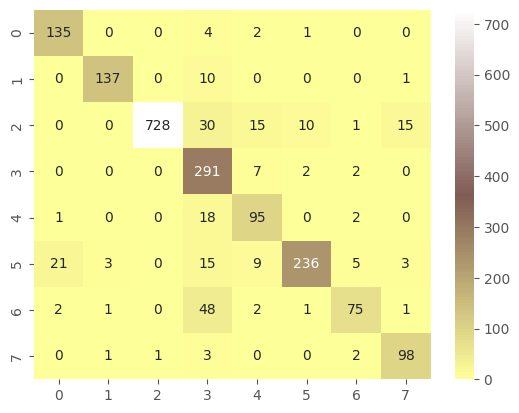

In [160]:
CM = confusion_matrix(trueClasses, predictedClasses)
sns.heatmap(CM, center = True,cmap='terrain',annot=True ,fmt='.5g')
plt.show()

In [161]:
ClassificationReport = classification_report(trueClasses, predictedClasses)
print('Classification Report is : \n', ClassificationReport )

Classification Report is : 
               precision    recall  f1-score   support

           0       0.85      0.95      0.90       142
           1       0.96      0.93      0.94       148
           2       1.00      0.91      0.95       799
           3       0.69      0.96      0.81       302
           4       0.73      0.82      0.77       116
           5       0.94      0.81      0.87       292
           6       0.86      0.58      0.69       130
           7       0.83      0.93      0.88       105

    accuracy                           0.88      2034
   macro avg       0.86      0.86      0.85      2034
weighted avg       0.90      0.88      0.88      2034



In [162]:
images = []
predictedClasses = []
trueClasses = []


class_labels = list(testGenerator.class_indices.keys())

for i in range(len(testGenerator)):
    img_batch, true_labels_batch = next(testGenerator)
    true_class_idx = np.argmax(true_labels_batch[0]) 

    prediction = Model.predict(img_batch)
    predicted_class_idx = np.argmax(prediction[0])

    predicted_class = class_labels[predicted_class_idx]
    true_class = class_labels[true_class_idx]

    images.append(np.squeeze(img_batch[0]))
    predictedClasses.append(predicted_class)
    trueClasses.append(true_class)

    if i >= 24: 
       break

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


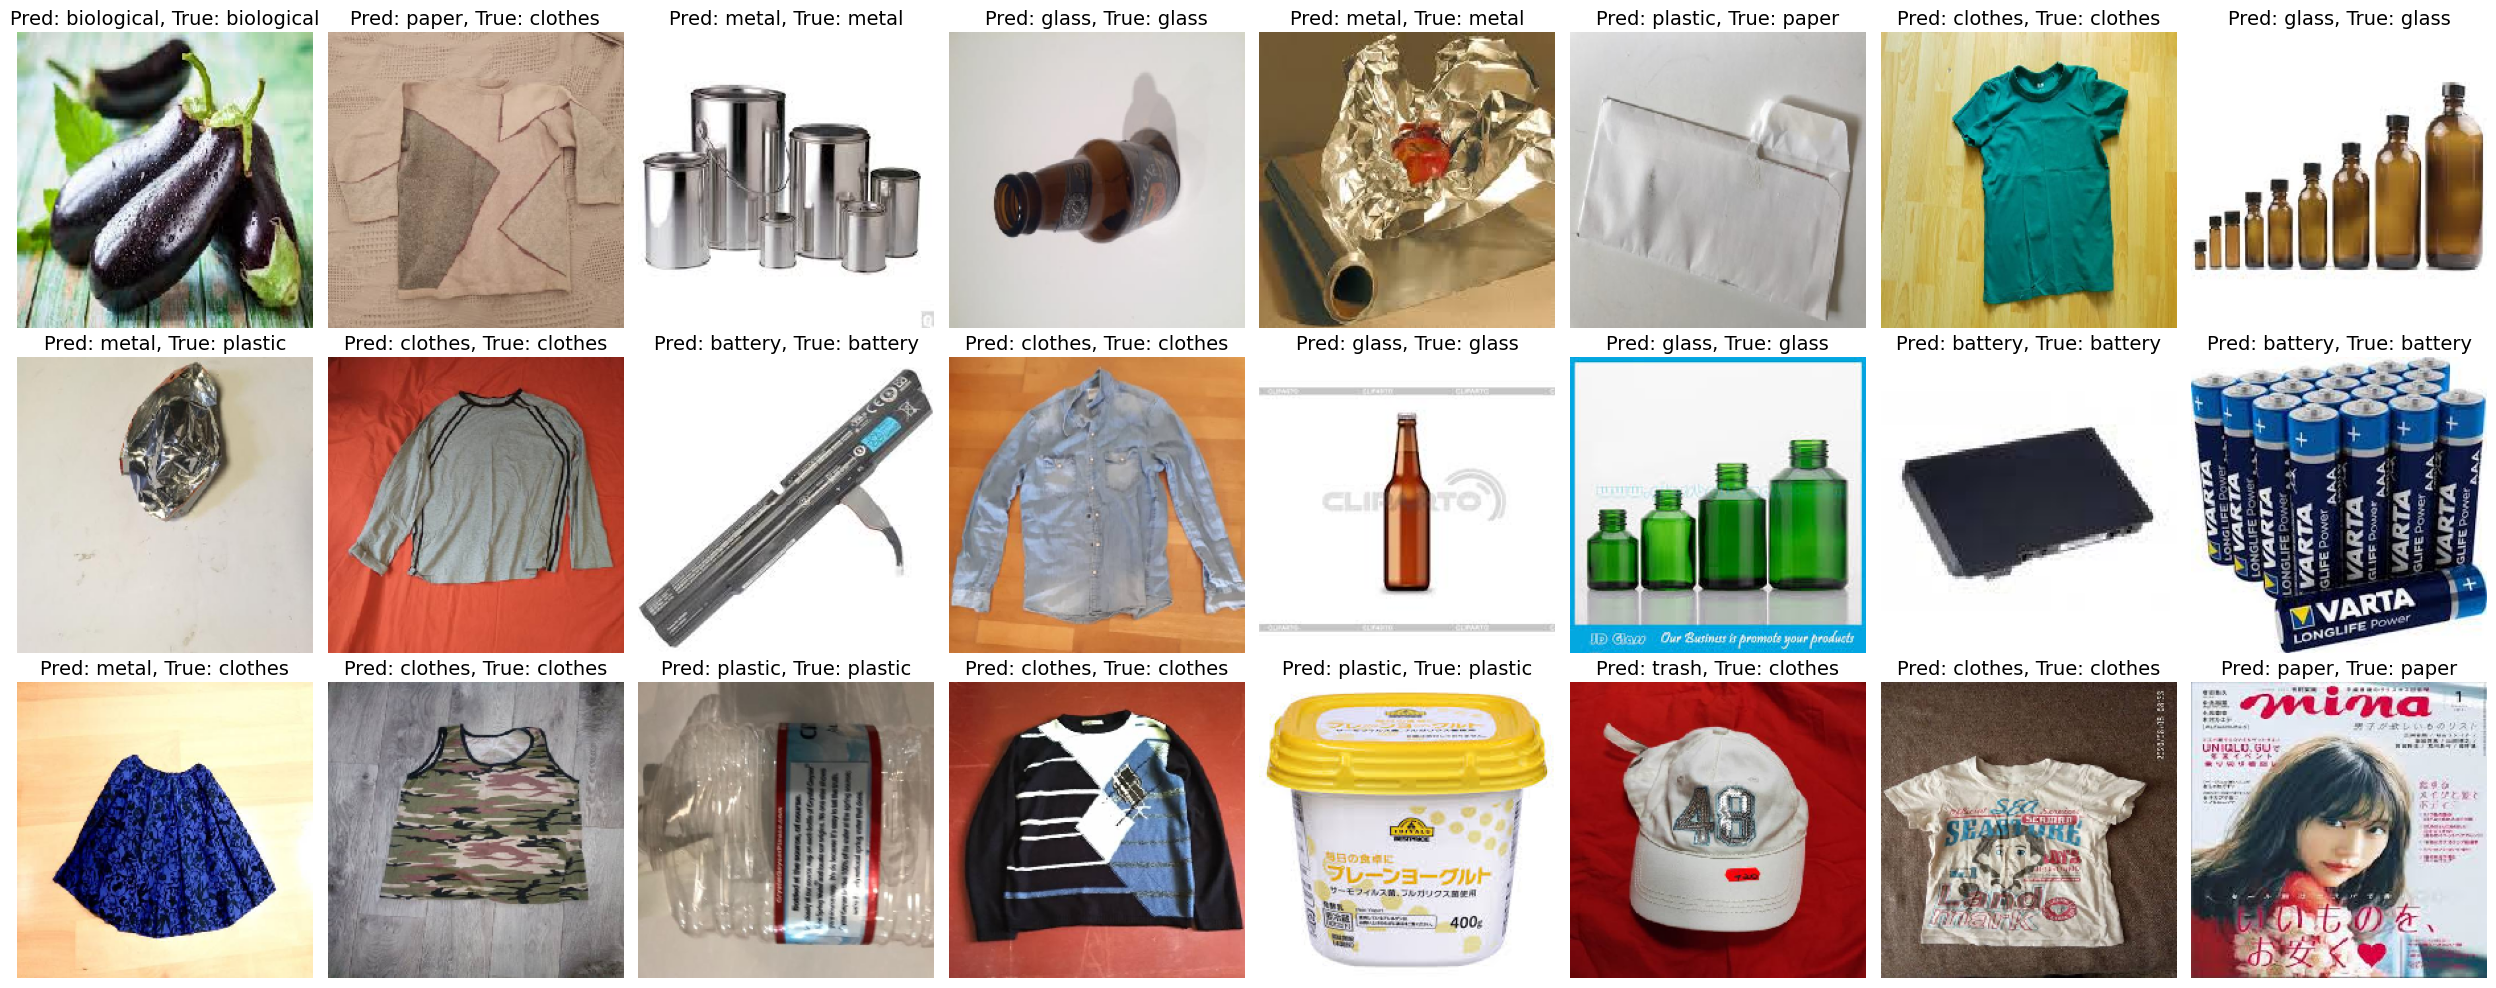

In [163]:
fig, axs = plt.subplots(3, 8, figsize=(25, 10))

axs = axs.flatten()

for ax,img , pred , true in zip(axs , images , predictedClasses , trueClasses):
    ax.imshow(img)
    ax.set_title(f"Pred: {pred}, True: {true}" ,fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()

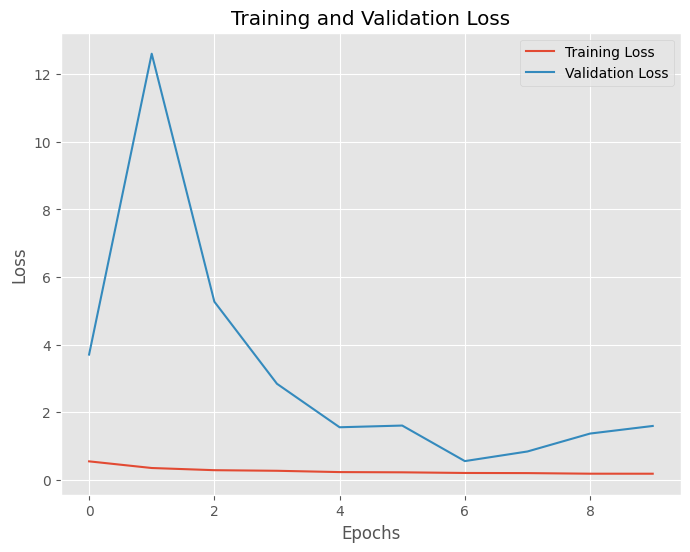

In [165]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [179]:
Model.save('MobileNetV2.h5')